In [1]:
import csv
import math
import os
import pickle
import scipy
import shutil
import time
import zipfile

import numpy  as np
import pandas as pd
import tensorflow as tf


from collections import deque
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.layers import Dense, Lambda, Input, BatchNormalization
from keras.models import load_model, Model, model_from_json
from keras.optimizers import Adam, RMSprop
from keras.preprocessing import image
from keras import backend as K
from matplotlib import pyplot as plt


Using TensorFlow backend.


In [2]:
INPUTS_FNAME   = "lfw_datasets_and_models.zip"

PATH_INPUTS_FNAME     = "./lfw_datasets_and_models.zip" 
PATH_INPUTS           = "./lfw_datasets_and_models"

PATH_DATASET_BASE     = PATH_INPUTS + "/datasets"

PATH_DATASET_BASE_MASKED   = PATH_DATASET_BASE + "/masked"
PATH_DATASET_BASE_UNMASKED = PATH_DATASET_BASE + "/unmasked"

PATH_DATASET_MASKED_TRAIN = PATH_DATASET_BASE_MASKED + "/train/"
PATH_DATASET_MASKED_VAL   = PATH_DATASET_BASE_MASKED + "/validation/"
PATH_DATASET_MASKED_TEST  = PATH_DATASET_BASE_MASKED + "/test/"

PATH_DATASET_UNMASKED_TRAIN = PATH_DATASET_BASE_UNMASKED + "/train/"
PATH_DATASET_UNMASKED_VAL   = PATH_DATASET_BASE_UNMASKED + "/validation/"
PATH_DATASET_UNMASKED_TEST  = PATH_DATASET_BASE_UNMASKED + "/test/"

PATH_TRAIN_RESNET = PATH_INPUTS + '/models/resnet/retrained/'
PATH_TRAIN_FACENET = PATH_INPUTS + '/models/facenet/retrained/'
PATH_TRAIN_DATASET = PATH_INPUTS + '/training'
PATH_TRAIN_ANCHOR_DATASET = PATH_TRAIN_DATASET + '/anchor/'
PATH_TRAIN_POSITIVE_DATASET = PATH_TRAIN_DATASET + '/positive/'

PATH_FACENET_KERAS_H5 = PATH_INPUTS + "/models/facenet/pretrained/model/facenet_keras.h5"

TRIPLET_LOSS_MARGIN = 2

IMAGE_INPUT_SIZE = 224

In [3]:
def extract_zipfile(filename: str, extract_dirname: str, extract_path: str):
    # Extract the inputs from the zip file.
    if (not os.path.isdir(extract_dirname)):
        print("[INFO] Extracting from '{}' to '../'...".format(filename), end=" ")
        with zipfile.ZipFile(filename, "r") as zip_ref:
            zip_ref.extractall(extract_path)
        print("DONE.")
    else:
        print("[INFO] Directory '{}' exists.".format(extract_dirname))

# extract_zipfile(PATH_INPUTS_FNAME, PATH_INPUTS, "./")

In [4]:
# [Retraing]
def triplet_loss(inputs, dist='euclidean', margin='maxplus'):
    anchor, positive, negative = inputs
    positive_distance = K.square(anchor - positive)
    negative_distance = K.square(anchor - negative)
    if dist == 'euclidean':
        positive_distance = K.sqrt(K.sum(positive_distance, axis=-1, keepdims=True))
        negative_distance = K.sqrt(K.sum(negative_distance, axis=-1, keepdims=True))
    elif dist == 'sqeuclidean':
        positive_distance = K.sum(positive_distance, axis=-1, keepdims=True)
        negative_distance = K.sum(negative_distance, axis=-1, keepdims=True)
    loss = positive_distance - negative_distance
    if margin == 'maxplus':
        loss = K.maximum(0.0, TRIPLET_LOSS_MARGIN + loss)
    elif margin == 'softplus':
        loss = K.log(1 + K.exp(loss))
        
    returned_loss = K.mean(loss)
    return returned_loss

In [5]:
# [Retraining]
# Used when compiling the siamese network
def identity_loss(y_true, y_pred):
    return K.mean(y_pred - 0 * y_true)  # This is actually just returning y_pred bcs
                                        # K.mean has already been called in the triplet_loss function

In [6]:
# [Retraining]
def get_siamese_from_resnet50():
    model = ResNet50(weights='imagenet')
    print(len(model.layers))
    model.layers.pop()
    #model.summary()

    layers_count = len(model.layers)
    for i in range(layers_count - 1):
        layer = model.layers[i]
        if i < layers_count//2:
            layer.trainable = False # Freeze first half of layers.
        elif layer.trainable and not layer.name.startswith("bn"):
            layer.trainable = False # Leave all BatchNorm layers to retrain.

    last_layer = model.layers[layers_count - 1]
    assert last_layer.trainable == True # Ensure last layer to retrain.

    # Define the siamese facenet network
    image_shape = (IMAGE_INPUT_SIZE, IMAGE_INPUT_SIZE, 3)

    model_out = last_layer.output
    model_out = Dense(128, activation = 'relu',  name = 'model_out')(model_out)
    model_out = BatchNormalization(axis = 1, epsilon=0.00001, name = 'BatchNorm_last')(model_out)
    model_out = Lambda(lambda  x: K.l2_normalize(x, axis = 1))(model_out)

    new_model = Model(inputs=model.input, outputs=model_out)

    anchor_input = Input(shape=image_shape, name='anchor_input')
    pos_input = Input(shape=image_shape, name='pos_input')
    neg_input = Input(shape=image_shape, name='neg_input')

    encoding_anchor = new_model(anchor_input)
    encoding_pos = new_model(pos_input)
    encoding_neg = new_model(neg_input)

    loss = Lambda(triplet_loss)([encoding_anchor, encoding_pos, encoding_neg])

    siamese_facenet = Model(inputs  = [anchor_input, pos_input, neg_input], outputs = loss)
    siamese_facenet.compile(optimizer=Adam(lr = .01, clipnorm = 1.), loss = identity_loss)
    siamese_facenet.summary()
    return new_model, siamese_facenet

In [7]:
IMAGE_TARGET_SHAPE = (IMAGE_INPUT_SIZE, IMAGE_INPUT_SIZE)
    
def get_image_tensor(image_path :str, image_target_shape = IMAGE_TARGET_SHAPE):
    image_tensor = image.load_img(image_path, target_size = image_target_shape)
    image_tensor = image.img_to_array(image_tensor)
    image_tensor = np.expand_dims(image_tensor, axis=0)
    image_tensor = preprocess_input(image_tensor)
    return image_tensor

In [8]:
def create_triplets(images_path :str, num_triplets_required = 50000):
    images_subdir = []
    for subdir in os.listdir(images_path):
        if len(images_subdir) == num_triplets_required:
            break
        filenames = os.listdir(images_path + subdir)
        
        # Skip directory with single image.
        if len(filenames) < 2:
            continue
        images_subdir.append(subdir)

    print("Total pairs found : " + str(len(images_subdir)))
    image_input_shape = (len(images_subdir), IMAGE_INPUT_SIZE, IMAGE_INPUT_SIZE, 3)
    
    anchor_imgs = np.empty(image_input_shape)
    pos_imgs = np.empty(image_input_shape)
    neg_imgs = np.empty(image_input_shape)
    for idx, subdir in enumerate(images_subdir):
        filenames = os.listdir(images_path + subdir)
        assert len(filenames) > 1
        image_path = images_path + subdir + "/" + filenames[0]
        anchor_imgs[idx] = get_image_tensor(image_path)

        image_path = images_path + subdir + "/" + filenames[1]
        pos_imgs[idx] = get_image_tensor(image_path)

    # Rotate pos_imgs by 1 to make them negative for other faces.
    neg_imgs = np.roll(pos_imgs, 1, axis = 0)
    return (anchor_imgs, pos_imgs, neg_imgs)

In [9]:
def create_unmasked_and_masked_triplets(unmasked_images_path :str, masked_images_path :str, 
                                        num_triplets_required = 50000):
    masked_dict = {}
    unmasked_path = []
    
    # Create pairs (subdir, filename) for unmasked images.
    for subdir in os.listdir(unmasked_images_path):
        filenames = os.listdir(unmasked_images_path + subdir)
        filename = unmasked_images_path + subdir + "/" + filenames[0]
        unmasked_path.append((subdir, filename))

    # Create dictionary {subdir : filename} for maksed images to join with unmasked.
    for subdir in os.listdir(masked_images_path):
        filenames = os.listdir(masked_images_path + subdir)
        filename = masked_images_path + subdir + "/" + filenames[0]
        masked_dict[subdir] = filename

    image_pairs = []
    for i in range(len(unmasked_path)):
        if len(image_pairs) == num_triplets_required:
            break
        anchor_name, anchor_path = unmasked_path[i]
        if anchor_name not in masked_dict:
            continue
        pos_path = masked_dict[anchor_name]
        image_pairs.append((anchor_path, pos_path))
        
    print("Total pairs found : " + str(len(image_pairs)))
    image_input_shape = (len(image_pairs), IMAGE_INPUT_SIZE, IMAGE_INPUT_SIZE, 3)
    
    anchor_imgs = np.empty(image_input_shape)
    pos_imgs = np.empty(image_input_shape)
    neg_imgs = np.empty(image_input_shape)
    for idx, image_pair in enumerate(image_pairs):
        anchor_imgs[idx] = get_image_tensor(image_pair[0])
        pos_imgs[idx] = get_image_tensor(image_pair[1])

    # Rotate pos_imgs by 1 to make them negative for other faces.
    neg_imgs = np.roll(pos_imgs, 1, axis = 0)
    return (anchor_imgs, pos_imgs, neg_imgs)

In [10]:
anchor1, pos1, neg1 = create_triplets(PATH_DATASET_UNMASKED_TRAIN)
anchor2, pos2, neg2 = create_triplets(PATH_DATASET_MASKED_TRAIN)
anchor3, pos3, neg3 = create_unmasked_and_masked_triplets(PATH_DATASET_UNMASKED_TRAIN, PATH_DATASET_MASKED_TRAIN)

anchor_images = np.concatenate((anchor1, anchor2, anchor3), axis = 0)
pos_images = np.concatenate((pos1, pos2, pos3), axis = 0)
neg_images = np.concatenate((neg1, neg2, neg3), axis = 0)

print(anchor_images.shape)
print(pos_images.shape)
print(neg_images.shape)

# Ensure neg_images are rotated version of pos_images
print(pos_images[0][0][0])
print(neg_images[1][0][0])

training_loss = []
z = np.zeros(len(anchor_images))
# print(len(z))

Total pairs found : 1389
Total pairs found : 600
Total pairs found : 5721
(7710, 224, 224, 3)
(7710, 224, 224, 3)
(7710, 224, 224, 3)
[-103.93900299 -115.77899933 -123.68000031]
[-103.93900299 -115.77899933 -123.68000031]


In [11]:
import warnings
warnings.filterwarnings('ignore')
new_model, siamese_model = get_siamese_from_resnet50()














177

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
anchor_input (InputLayer)       (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
pos_input (InputLayer)          (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
neg_input (InputLayer)          (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 128)          23850496    anchor_input[0][0]               
                                                                 pos_input[0][0]           

In [ ]:
EPOCHS_COUNT = 75
BATCH_SIZE = 32

for epoch in range(EPOCHS_COUNT):
    siamese_model.fit(x=[anchor_images, pos_images, neg_images], 
                    y=z, 
                    batch_size=BATCH_SIZE, 
                    epochs=1, 
                    verbose=1, 
                    callbacks=None, 
                    validation_split=0.0, 
                    validation_data=None, 
                    shuffle=True, 
                    class_weight=None, 
                    sample_weight=None, 
                    initial_epoch=0, 
                    steps_per_epoch=None, 
                    validation_steps=None)
    training_loss.append(siamese_model.history.history['loss'])
    
    # Rotate negatives in triplets for next epoch.
    neg1 = np.roll(neg1, 1, axis = 0)
    neg2 = np.roll(neg2, 1, axis = 0)
    neg3 = np.roll(neg3, 1, axis = 0)
    neg_images = np.concatenate((neg1, neg2, neg3), axis = 0)
    
    if (epoch % 5 == 0 and training_loss[-1][0] > 0):
        # Create and save the Encoding Network to use in predictions.
        encoding_input = Input(shape=(IMAGE_INPUT_SIZE, IMAGE_INPUT_SIZE, 3), name='resnet_encoding_input')
        encoding_output = new_model(encoding_input)
        encoding_resnet = Model(inputs  = encoding_input, outputs = encoding_output)

        weights = siamese_model.get_layer('model_1').get_weights()
        encoding_resnet.get_layer('model_1').set_weights(weights)

        # Save the Encoding Network architecture
        encoding_model_json = encoding_resnet.to_json()
        with open(PATH_TRAIN_RESNET + "/encoding_resnet_arch.json", "w") as json_file:
            json_file.write(encoding_model_json)
        # save the Encoding Network model weights    
        encoding_resnet.save_weights(PATH_TRAIN_RESNET + '/encoding_resnet_weights.h5')


Epoch 1/1
7710/7710 [==============================] - 441s 57ms/step - loss: 1.0681
Epoch 1/1
3520/7710 [============>.................] - ETA: 4:00 - loss: 1.0602

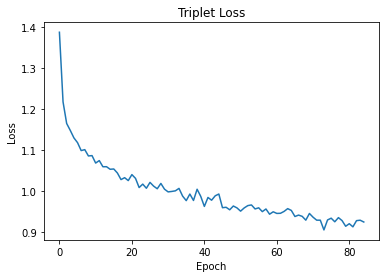

In [21]:
plt.figure()
title = 'Triplet Loss'
plt.title(title)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(training_loss)

In [14]:
# # Training completed at this point. Save the model architecture and weights.
# # Save the Siamese ResNet50 Network architecture
# siamese_model_json = siamese_model.to_json()
# with open(PATH_TRAIN_RESNET + "/siamese_resnet_arch.json", "w") as json_file:
#     json_file.write(siamese_model_json)
# # save the Siamese Network model weights
# siamese_model.save_weights(PATH_TRAIN_RESNET + "/siamese_resnet_weights.h5")

# # create and save the Encoding Network to use in predictions later on
# encoding_input = Input(shape=(IMAGE_INPUT_SIZE, IMAGE_INPUT_SIZE, 3), name='resnet_encoding_input')
# encoding_output = new_model(encoding_input)
# encoding_resnet = Model(inputs  = encoding_input, outputs = encoding_output)

# weights = siamese_model.get_layer('model_1').get_weights()
# encoding_resnet.get_layer('model_1').set_weights(weights)

# # Save the Encoding Network architecture
# encoding_model_json = encoding_resnet.to_json()
# with open(PATH_TRAIN_RESNET + "/encoding_resnet_arch.json", "w") as json_file:
#     json_file.write(encoding_model_json)
# # save the Encoding Network model weights    
# encoding_resnet.save_weights(PATH_TRAIN_RESNET + '/encoding_resnet_weights.h5')

In [15]:
# positive_encodings = []
# for i in range(len(pos_images)):
#     encoding = encoding_facenet.predict([pos_images[i:i+1]], batch_size = 1, verbose = 0)
#     positive_encodings.append(encoding)

# for i in range(25):
#     anchor_encoding = encoding_facenet.predict([anchor_images[i:i+1]], batch_size = 1, verbose = 0)
#     min_distance = 10000
#     min_index = -1
#     for j in range(len(positive_encodings)):
#         if i == j:
#             continue
#         distance = np.linalg.norm(anchor_encoding - positive_encodings[j])
#         assert distance >= 0
#         if distance < min_distance:
#             min_distance = distance
#             min_index = j
    
#     pos_distance = np.linalg.norm(anchor_encoding - positive_encodings[i])
#     if (pos_distance <= min_distance):
#         print(str(i) + " postive distance   : " + str(pos_distance))
#         print(str(min_index) + " negative distance : " + str(min_distance))